In [64]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

Ознакомление с данными, разведочных анализ, базовая аналитика:

In [34]:
### Получение фрейма данных ###

# Подключение к БД
conn = sqlite3.connect('data/skins_analytics.db')

# Текст запроса
query = """
SELECT *
FROM skin_prices 
WHERE skin_name = 'AK-47 | Redline (Field-Tested)'
ORDER BY collected_at ASC
"""

# Выполнение запроса 
df = pd.read_sql(query, conn)
conn.close()

In [36]:
### Предобработка данных ###

# Перевод в формат даты времени
df['collected_at'] = pd.to_datetime(df['collected_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])

# Конвертируем цены
df['price_usd'] = df['price'] / 100 # Центы в доллары
df['original_price'] = df['original_price'] / 100 # Фэни в юани

In [71]:
# Форматирование будущих графиков

plt.style.use('dark_background')
bg_color = '#0b0f19'
grid_color = '#1f293d'
neon_cyan = '#08F7FE'
neon_pink = '#FE53BB'
neon_green = '#00ff41'

Всего записей: 96
Период сбора: 2026-02-17 09:00 -> 2026-02-19 08:00
Диапазон собранных данных: 1 days 23:00:00
Источники данных: buff163, skins



,row_count,min_price,max_price,mean_price,std,volatility_%
source,,,,,,
buff163,48,34.74,35.90,35.374,0.171,0.483
skins,48,34.58,36.03,35.110,0.225,0.642


На старте работы парсера он неправильно обращался к API, 
передавая некорректные значения параметров средних и медианных значений при get-запросе, получилось:
avg_7        20
avg_30       20
median_7     20
median_30    20
dtype: int64


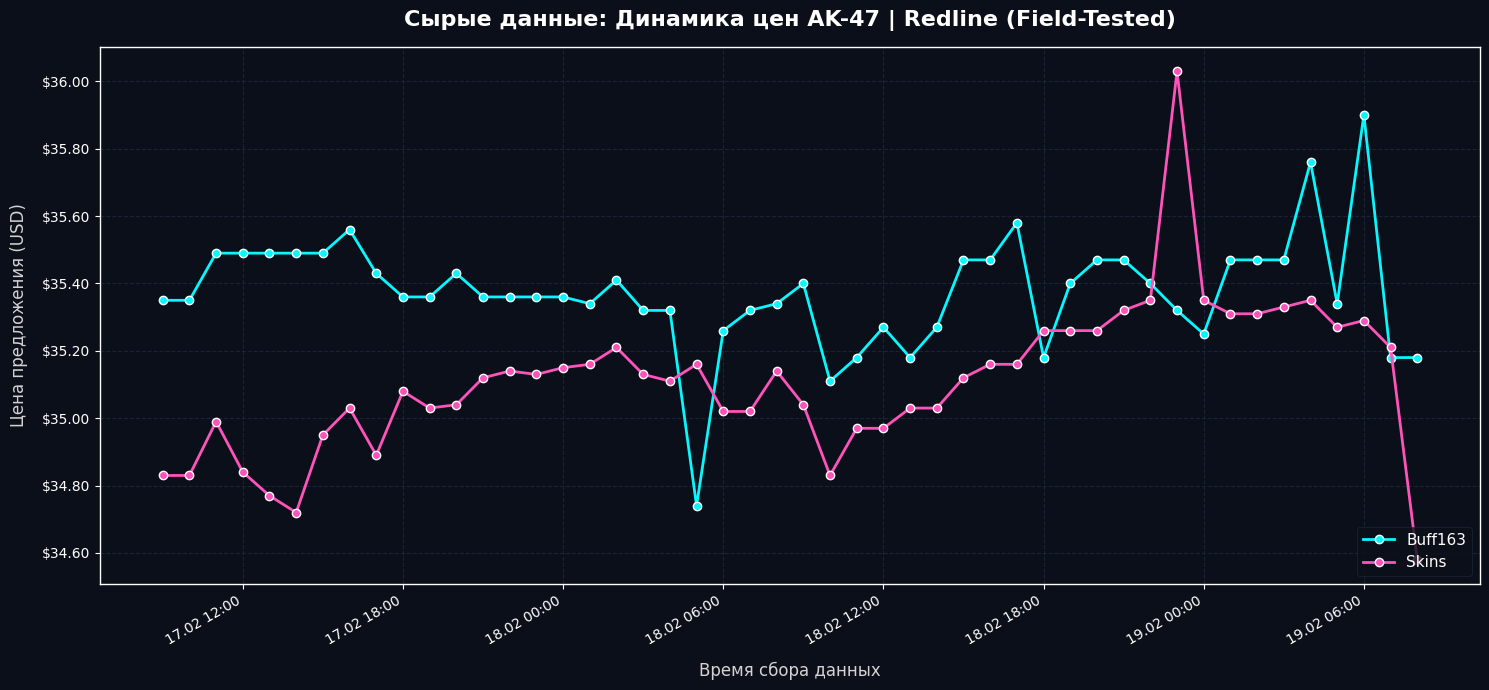

In [76]:
### Вывод базовых метрик ###

# Общая информация
print(f"Всего записей: {len(df)}")
print(f"Период сбора: {df['collected_at'].min().strftime('%Y-%m-%d %H:%M')} -> {df['collected_at'].max().strftime('%Y-%m-%d %H:%M')}")
print(f'Диапазон собранных данных: {df['collected_at'].max() - df['collected_at'].min()}')
print(f"Источники данных: {', '.join(df['source'].unique())}\n")

# Описательная статистика
stats = df.groupby('source')['price_usd'].agg(
    row_count='count',
    min_price='min',
    max_price='max',
    mean_price='mean',
    std='std'
)
stats['volatility_%'] = (stats['std'] / stats['mean_price']) * 100
display(stats.round(3))

# Проверка на пропуски данных
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print("""На старте работы парсера он неправильно обращался к API, 
передавая некорректные значения параметров средних и медианных значений при get-запросе, получилось:""")
print(missing_data)

# Визуализация сырого ценового ряда
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
colors = {'buff163': neon_cyan, 'skins': neon_pink}

for source in df['source'].unique():
    subset = df[df['source'] == source]
    ax.plot(
        subset['collected_at'], 
        subset['price_usd'], 
        marker='o', 
        markersize=6,
        color=colors[source], 
        linewidth=2,
        markeredgecolor='white',
        label=f'{source.capitalize()}'
    )

plt.title('Сырые данные: Динамика цен AK-47 | Redline (Field-Tested)', fontsize=16, fontweight='bold', color='white', pad=15)
plt.xlabel('Время сбора данных', fontsize=12, color='lightgray', labelpad=10)
plt.ylabel('Цена предложения (USD)', fontsize=12, color='lightgray', labelpad=10)

# Единообразное форматирование
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
plt.xticks(rotation=30, ha='right')

plt.legend(loc='lower right', fontsize=11, facecolor=bg_color, edgecolor=grid_color, labelcolor='white')
plt.grid(True, color=grid_color, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()


Расчёт актуальных цен

Заметим, что метрика count сильно отличается между площадками:


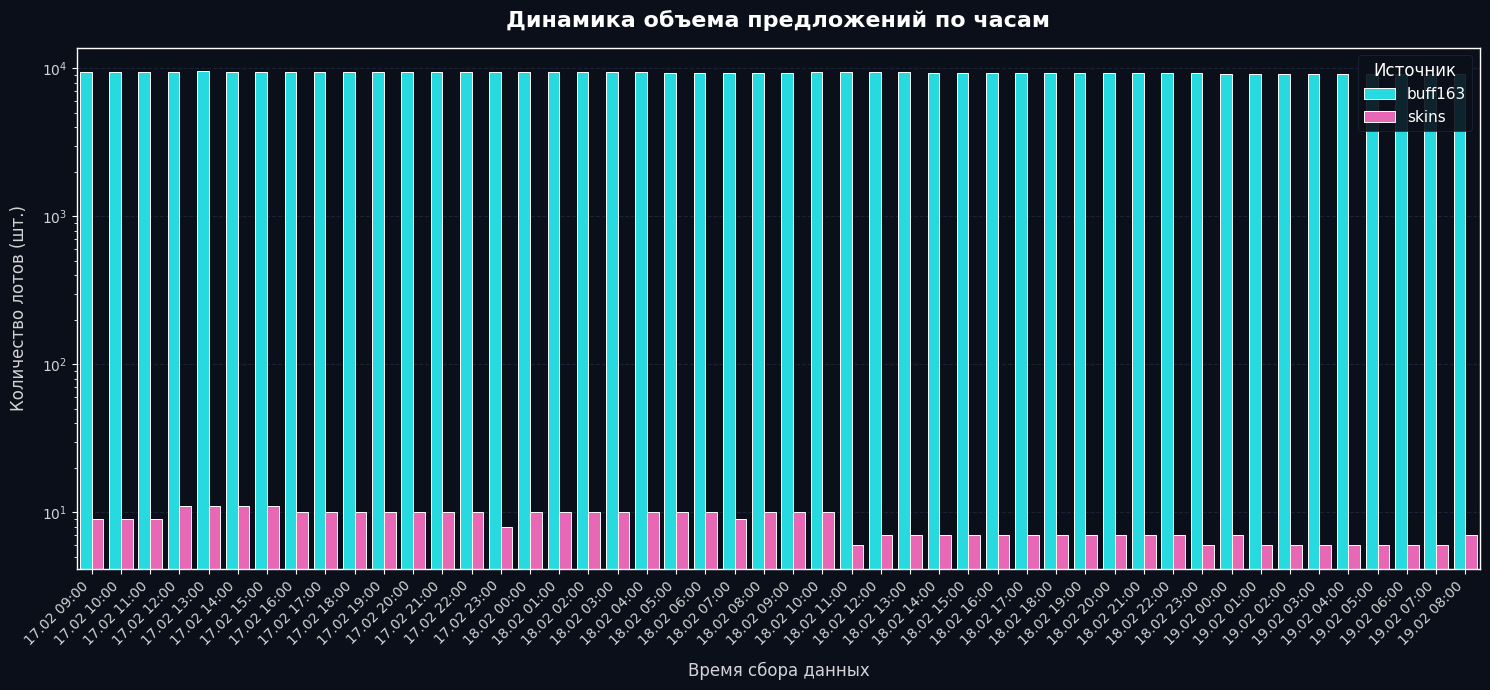

In [84]:
# Инсайт про метрику count
print('Заметим, что метрика count сильно отличается между площадками:')

df['hour_label'] = df['collected_at'].dt.strftime('%d.%m %H:00')

fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

sns.barplot(
    data=df,
    x='hour_label',
    y='count',
    hue='source',
    palette={'buff163': neon_cyan, 'skins': neon_pink},
    edgecolor='white',
    linewidth=0.7,
    ax=ax
)

plt.title('Динамика объема предложений по часам', fontsize=16, fontweight='bold', color='white', pad=15)
plt.xlabel('Время сбора данных', fontsize=12, color='lightgray', labelpad=10)
plt.ylabel('Количество лотов (шт.)', fontsize=12, color='lightgray', labelpad=10)

plt.xticks(rotation=45, ha='right', color='lightgray')
plt.yticks(color='lightgray')

# Логарифмическая шкала, чтобы skins не пропал
plt.yscale('log')

plt.legend(
    title='Источник',
    loc='upper right',
    fontsize=11,
    title_fontsize=12,
    facecolor=bg_color,
    edgecolor=grid_color,
    labelcolor='white',
    framealpha=0.9
)

plt.grid(axis='y', color=grid_color, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

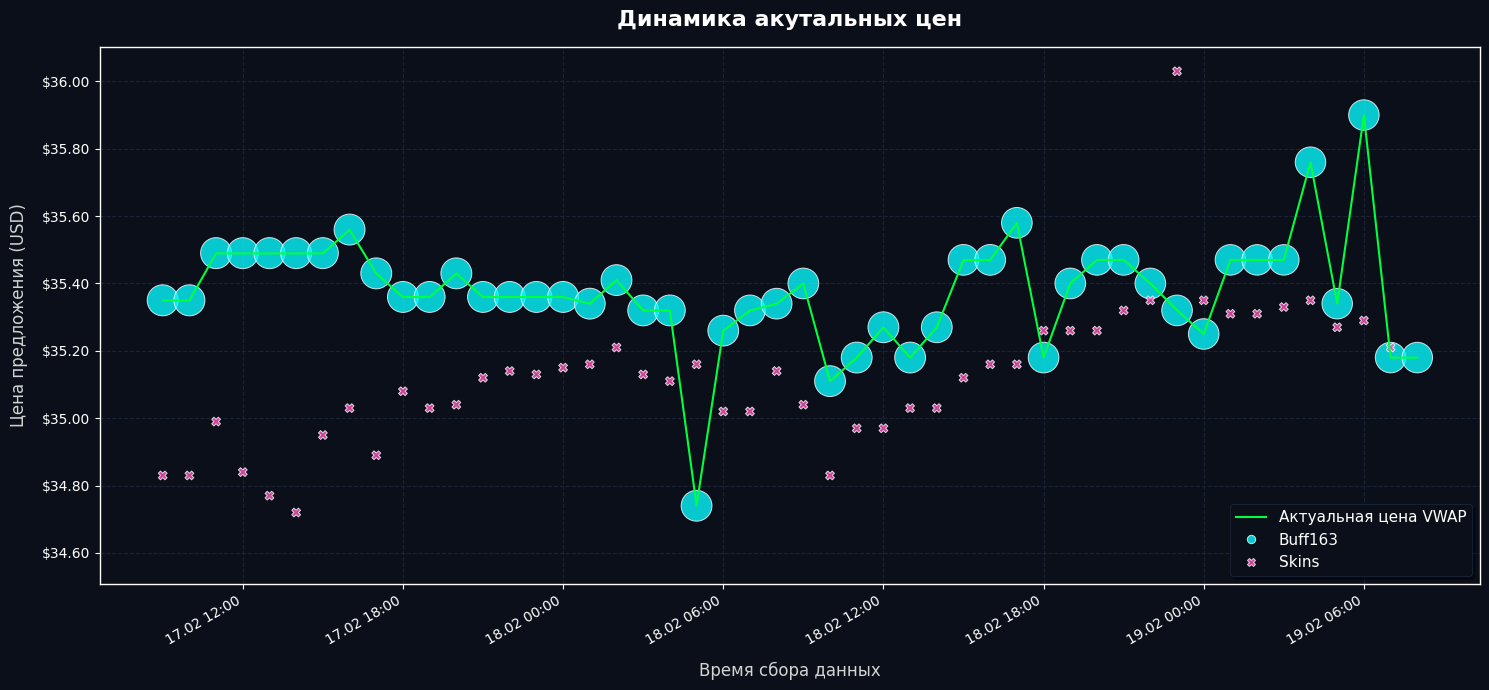

In [85]:
# Расчёт актуальных цен

# Используем средневзевенную цену по объему чтобы компенсировать такую диспропорцию в ликвидности
# Формула: Сумма(Объем*Цены)/Сумма(Объем)

# Функция расчёта
def calculate_vwap_for_group(group):
    if group['count'].sum() == 0:
        return group['price_usd'].mean()
    return (group['price_usd'] * group['count']).sum() / group['count'].sum()

# Выполняем расчёт
vwap_trend = df.groupby('collected_at').apply(calculate_vwap_for_group).reset_index(name='vwap_price')

# Рисуем график с визуальным представлением разницы в объемах - точки собранных цен по площадкам будут разного размера
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

sns.scatterplot(
    data=df, 
    x='collected_at', 
    y='price_usd', 
    hue='source', 
    style='source', 
    size='count',
    sizes=(40, 500),
    alpha=0.8,
    palette={'buff163': neon_cyan, 'skins': neon_pink},
    edgecolor='white',
    linewidth=0.7,
    ax=ax
)

# Рисуем линию актуальных цен VWAP
ax.plot(
    vwap_trend['collected_at'], 
    vwap_trend['vwap_price'], 
    color=neon_green, 
    linewidth=1.5, 
    linestyle='-',
    zorder=4,
    label='Актуальная цена VWAP'
)

plt.title('Динамика акутальных цен', fontsize=16, fontweight='bold', color='white', pad=15)
plt.xlabel('Время сбора данных', fontsize=12, color='lightgray', labelpad=10)
plt.ylabel('Цена предложения (USD)', fontsize=12, color='lightgray', labelpad=10)

# Единообразное форматирование
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
plt.xticks(rotation=30, ha='right')

handles, labels = ax.get_legend_handles_labels()
clean_handles = [handles[-1], handles[1], handles[2]] 
clean_labels = ['Актуальная цена VWAP', 'Buff163', 'Skins']

plt.legend(
    clean_handles, 
    clean_labels, 
    loc='lower right', 
    fontsize=11, 
    frameon=True, 
    facecolor=bg_color, 
    edgecolor=grid_color, 
    labelcolor='white',
    shadow=True
)

plt.grid(True, color=grid_color, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

Вывод: При таком методе расчёта актуальной цены ценообразующим источником становится Buff163 так как его объем предложения несоизмеримо больше чем у skins.

ML-расчёт ценового тренда

Динамика акуальных цен: 0.0003 USD в час (0.01 USD в сутки).


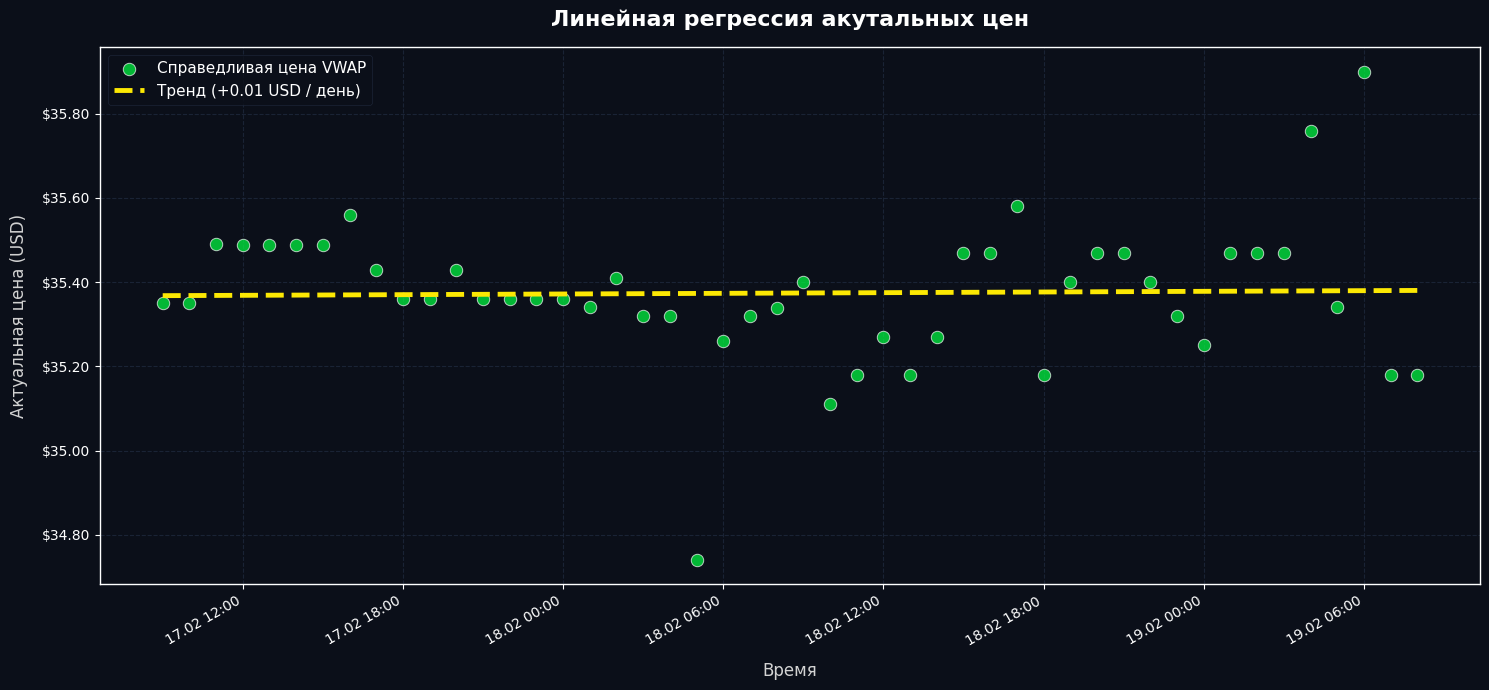

In [87]:
# Создаём признаки

df_ml = vwap_trend.copy()

# Часы с начала сбора данных
start_time = df_ml['collected_at'].min()
df_ml['hours_passed'] = (df_ml['collected_at'] - start_time).dt.total_seconds() / 3600.0

X = df_ml[['hours_passed']].values
y = df_ml['vwap_price'].values

# Простая линейная регрессия
model = LinearRegression()
model.fit(X, y)

# Получаем предсказания 
df_ml['trend_prediction'] = model.predict(X)
slope_per_hour = model.coef_[0]
slope_per_day = slope_per_hour * 24

print(f"Динамика акуальных цен: {slope_per_hour:.4f} USD в час ({slope_per_day:.2f} USD в сутки).")

# Визуализация
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

ax.scatter(
    df_ml['collected_at'], 
    df_ml['vwap_price'], 
    color=neon_green, 
    s=80, 
    alpha=0.7, 
    edgecolor='white',
    linewidth=0.7,
    label='Справедливая цена VWAP'
)

# Рисуем линию тренда
ax.plot(
    df_ml['collected_at'], 
    df_ml['trend_prediction'], 
    color=neon_yellow, 
    linewidth=3.5, 
    linestyle='--',
    label=f'Тренд ({slope_per_day:+.2f} USD / день)'
)

plt.title('Линейная регрессия акутальных цен', fontsize=16, fontweight='bold', color='white', pad=15)
plt.xlabel('Время', fontsize=12, color='lightgray', labelpad=10)
plt.ylabel('Актуальная цена (USD)', fontsize=12, color='lightgray', labelpad=10)

formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
plt.xticks(rotation=30, ha='right')

plt.legend(
    loc='upper left', 
    fontsize=11, 
    frameon=True, 
    facecolor=bg_color, 
    edgecolor=grid_color, 
    labelcolor='white'
)
plt.grid(True, color=grid_color, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()